In [56]:
import os
import re
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# MAPPING DATASETS

In [57]:
# Map Kaggle and Mendeley labels to unified set
label_map = {
    "URTI": "URTI",
    "Healthy": "Healthy",
    "Asthma": "Asthma",
    "COPD": "COPD",
    "LRTI": "LRTI",
    "Pneumonia": "Pneumonia",
    "Bronchiectasis": "BRON",
    "Bronchiolitis": "BRON",
    "BRON": "BRON",
    "Lung Fibrosis":"Lung Fibrosis",
    "Plueral Effusion":"Plueral Effusion"
}

In [58]:
class Diagnosis():
  def __init__ (self, id, diagnosis, audio_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.audio_path = audio_path   

# CLEANING & PARSING: Mendeley Dataset

In [59]:
# extract labels for Mendeley dataset
path_mendeley = "audioDataMendeley/Audio files"

keep_upper = {"COPD", "BRON"}
diagnosis_list =[]

# Detect diagnosis text in the filename and format it properly.
def format_diagnosis_from_filename(filename):
    name, ext = os.path.splitext(filename)
    
    # Split on first underscore
    parts = name.split("_", 1)
    if len(parts) > 1:
        prefix, diag_segment = parts[0], parts[1]
        
        # Split the diagnosis segment by commas
        diag_parts = diag_segment.split(",")
        formatted_diag_parts = []
        for part in diag_parts:
            part_clean = part.strip()
            if part_clean.upper() in keep_upper:
                formatted_diag_parts.append(part_clean.upper())
            elif part_clean == "N":
                formatted_diag_parts.append("Healthy")
            else:
                formatted_diag_parts.append(part_clean.title())
        
        # Rejoin with commas
        new_diag_segment = ",".join(formatted_diag_parts)
        new_name = f"{prefix}_{new_diag_segment}"
    else:
        new_name = name
    
    return new_name + ext

# go through directory and only keep necessary files
mendeley_labels = []
data_mendeley = []
for c, file in enumerate(os.listdir(path_mendeley)):
    if file.endswith(".wav"):
        old_path = os.path.join(path_mendeley, file)

        if "heart failure" in file.lower() or "and" in file.lower():
            os.remove(old_path)
            continue

        new_filename = format_diagnosis_from_filename(file)
        new_path = os.path.join(path_mendeley, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)

        # make patient diagnosis csv
        filename_parts = new_filename.split("_")
        patient_id_pattern = r"\d+"

        # extract patient id and diagnosis from filename 
        match_id = re.search(patient_id_pattern,filename_parts[0])
        if match_id:
            patient_id_mendeley = int(match_id.group())

        diag_segment = filename_parts[1]
        patient_diagnosis_mendeley = diag_segment.split(",")[0].strip()
        
        data_mendeley.append([patient_id_mendeley,patient_diagnosis_mendeley])

        diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=patient_diagnosis_mendeley,
        audio_path=new_path
    ))
        
# export csv
patient_diagnosis_df_mendeley = pd.DataFrame(data_mendeley)
patient_diagnosis_df_mendeley.to_csv('audioDataMendeley/patient_diagnosis.csv', index=False)

# PARSING DATASET: Kaggle

In [60]:
# Download latest version of the database 
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/nikisingh/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [61]:
# extract lables for kaggle dataset
# Path to patient diagnosis CSV
diagnosis_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")

audio_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/")
files_kaggle = []
for file in os.listdir(audio_path_kaggle):
    if file.endswith(".wav"):
        files_kaggle.append(file)

files_kaggle = sorted(files_kaggle)

In [62]:
diag_dict_kaggle = { 101 : "URTI"}  
diagnosis_kaggle = pd.read_csv(diagnosis_path_kaggle)
  
for index , row in diagnosis_kaggle.iterrows():
    diag_dict_kaggle[row.iloc[0]] = row.iloc[1]

# Add kaggle files to diagnosis list
for c, f in enumerate(files_kaggle):
    patient_id = int(f.split('_')[0])
    raw_label = diag_dict_kaggle.get(patient_id, "Unknown")
    diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=label_map.get(raw_label, "Unknown"),
        audio_path=os.path.join(audio_path_kaggle, f)
    ))

# FEATURE EXTRACTION

In [63]:
unique_labels = sorted(set(d.diagnosis for d in diagnosis_list))

# Create a mapping from label
to_index = {label: idx for idx, label in enumerate(unique_labels)}
to_index

{'Asthma': 0,
 'BRON': 1,
 'COPD': 2,
 'Healthy': 3,
 'LRTI': 4,
 'Lung Fibrosis': 5,
 'Plueral Effusion': 6,
 'Pneumonia': 7,
 'URTI': 8}

In [64]:
# Collect all audio files and diagnosises in sets
audio_paths = [s.audio_path for s in diagnosis_list]
labels = [to_index[s.diagnosis] for s in diagnosis_list]

### Base Model

In [65]:
def extract_basic_model_features(audio_paths, target_sr=22050):
    # Load all audio files and return the audio file path, data, sample rate, and duration
    # Data is audio time series
    features = []

    for audio_file in audio_paths:
        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # compute STFT for chroma + contrast
        stft = np.abs(librosa.stft(y))

        # compute 1D audio features
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # concatenate all features into one 1D vector
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

        features.append(combined)

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension
    # Source: Appendix 2
    padded = padded[..., np.newaxis]  # shape: (samples, feature_length, 1) 

    return padded


### Data Augmented Model

In [66]:
def augment_audio(audio, sr, augmentation_type):
    if augmentation_type == 'noise':
        # generate an array of random numbers
        noise = np.random.randn(len(audio))
        # add noise to original audio
        audio = audio + 0.005 * noise
        # clip audio so values are within valid range (-1 to 1)
        audio = np.clip(audio, -1.0, 1.0)
    elif augmentation_type == 'pitch_shift':
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    elif augmentation_type == 'remix':
        # detect non-silent intervals
        intervals = librosa.effects.split(audio, top_db=20)
        # only remix if there are multiple intervals
        if len(intervals) > 1:  
            np.random.shuffle(intervals)
            audio = librosa.effects.remix(audio, intervals)
        audio = np.clip(audio, -1.0, 1.0)
    return audio

In [67]:
def extract_augmented_model_features(audio_paths,labels,target_sr=22050,augmentation_types=['noise', 'pitch_shift', 'time_stretch']):
    features = []
    new_labels = []

    # add original features to list + augmented features
    for i, audio_file in enumerate(audio_paths):

        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # data augmentation loop
        for aug in augmentation_types:
            y_aug = augment_audio(y.copy(), sr, aug)

            stft_aug = np.abs(librosa.stft(y_aug))
            mfccs = np.mean(librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40), axis=1)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft_aug, sr=sr), axis=1)
            mel = np.mean(librosa.feature.melspectrogram(y=y_aug, sr=sr), axis=1)
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft_aug, sr=sr), axis=1)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y_aug), sr=sr), axis=1)

            combined_aug = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

            features.append(combined_aug)
            new_labels.append(labels[i])

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension 
    # Source: Appendix 2
    padded = padded[..., np.newaxis]
    new_labels = np.array(new_labels)

    return padded, new_labels

### Location Focused Model

In [68]:
def extract_location_metadata(filename):
# extract chest location of where recording was taken from
# important to note, some samples will not be looked at because they don't fit into mapping
    location_map = {
        'A': 'Anterior',
        'P': 'Posterior',
        'T': 'Trachea',
        'L': 'Lateral',
    }
    if 'mendeley' in filename.lower():
        parts = filename.split(',')
        location_code = parts[-3].strip()[0]
        return location_map.get(location_code,'Unknown')
    elif 'kaggle' in filename.lower():
        parts = filename.split('_')
        location_code = parts[-3][0]
        return location_map.get(location_code, 'Unknown')
    return 'Unknown'

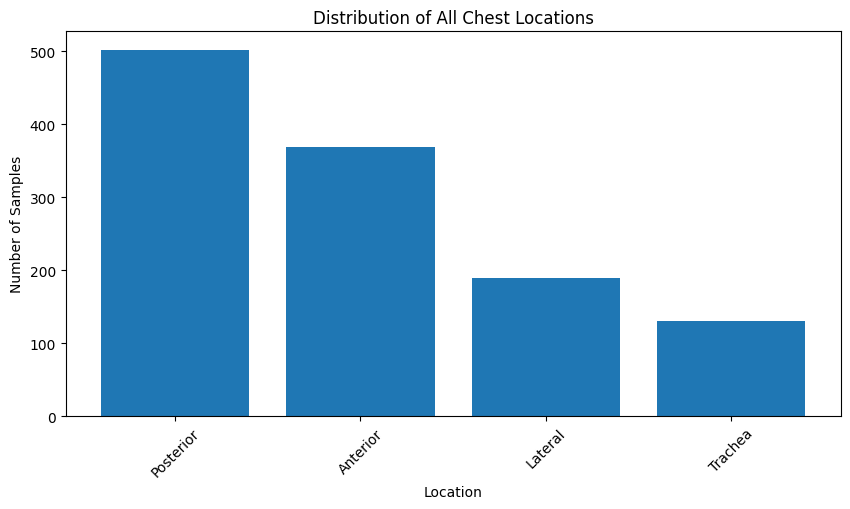

In [69]:
locations = [str(extract_location_metadata(f)) for f in audio_paths]
location_counts = Counter(locations)

# plot the distribution
plt.figure(figsize=(10,5))
plt.bar(location_counts.keys(), location_counts.values())
plt.xlabel('Location')
plt.ylabel('Number of Samples')
plt.title('Distribution of All Chest Locations')
plt.xticks(rotation=45)
plt.show()


We will not be using lateral, trachea, and unknown from our samples.

# PREPROCESSING

### Base and Augmented Model Splitting

In [70]:
# separate out the test set
train_val_paths, test_paths, y_train_val, y_test= train_test_split(
    audio_paths,labels, test_size=0.2, random_state=42, stratify=labels
)

# split the remaining paths into training and validation
train_paths, val_paths,y_train,y_val = train_test_split(
    train_val_paths, y_train_val,test_size=0.25, random_state=42, stratify=[labels[i] for i in range(len(train_val_paths))]
)

In [71]:
# set labels to variables
train_labels = to_categorical(y_train, num_classes=9)
val_labels = to_categorical(y_val, num_classes=9)
test_labels = to_categorical(y_test, num_classes=9)

### Base Model Features

In [72]:
base_features_train = extract_basic_model_features(train_paths)
base_features_val = extract_basic_model_features(val_paths)
base_features_test = extract_basic_model_features(test_paths)

In [73]:
print(base_features_train.shape) # 60%
print(base_features_val.shape) # 20%
print(base_features_test.shape) # 20%

(714, 193, 1)
(238, 193, 1)
(238, 193, 1)


### Data Augmented Model Features

In [74]:
# extract features from paths for augmentation
aug_features_train, aug_labels_train = extract_augmented_model_features(train_paths, y_train)

In [75]:
# Combine original and augmented features
aug_X_train = np.concatenate([base_features_train, aug_features_train], axis=0)
aug_y_train = np.concatenate([train_labels, to_categorical(aug_labels_train, num_classes=9)], axis=0)

# Keep validation and test sets as usual
aug_X_val = base_features_val
aug_y_val = val_labels

aug_X_test = base_features_test
aug_y_test = test_labels

In [76]:
print(aug_X_train.shape) 
print(aug_X_val.shape)
print(aug_X_test.shape)

(2856, 193, 1)
(238, 193, 1)
(238, 193, 1)


## Make CNN model bases

In [77]:
# Define model
# Source - Appendix 1
def create_cnn_model1(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [78]:
# Define model; change = added dropout between conv layers and adjusted dropout values
def create_cnn_model2(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [79]:
# Define model; change = F1 now using weighted instead of macro
def create_cnn_model3(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='weighted', threshold=0.5)
        ]
    )
    return model

# Modeling

### Run Base Model

In [80]:
# model 1 + base training set
model_base_1 = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_1 = model_base_1.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - f1_score: 0.0615 - loss: 9.1464 - precision: 0.4191 - recall: 0.3290 - val_f1_score: 0.0834 - val_loss: 6.0465 - val_precision: 0.7353 - val_recall: 0.5252
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - f1_score: 0.1111 - loss: 3.8142 - precision: 0.6576 - recall: 0.5467 - val_f1_score: 0.1163 - val_loss: 4.0373 - val_precision: 0.6776 - val_recall: 0.5210
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - f1_score: 0.1144 - loss: 2.7972 - precision: 0.7105 - recall: 0.4762 - val_f1_score: 0.0767 - val_loss: 1.7134 - val_precision: 0.8305 - val_recall: 0.4118
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - f1_score: 0.0764 - loss: 1.3737 - precision: 0.8573 - recall: 0.3926 - val_f1_score: 0.0795 - val_loss: 1.3090 - val_precision: 0.8045 - val_recall: 0.4496
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - f1_score: 0.0936 - loss: 1.1879 - precision: 0.8142 - recall: 0.4947 - val_f1_score: 0.0879 - val_loss: 1.0838 - val

F1 Score: 90.26%
Precision: 73.95%
Recall: 28.11%
Loss: 0.5403


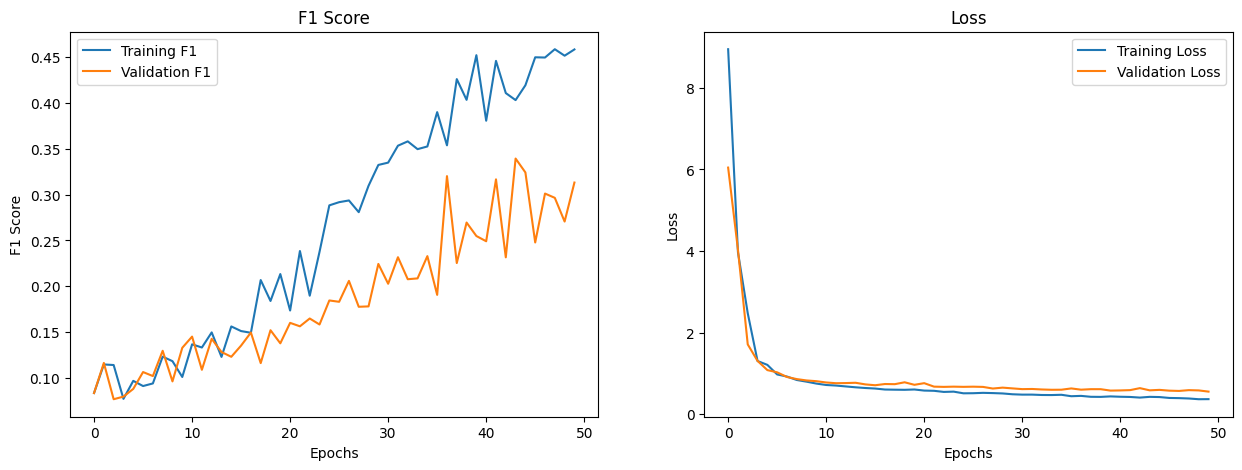

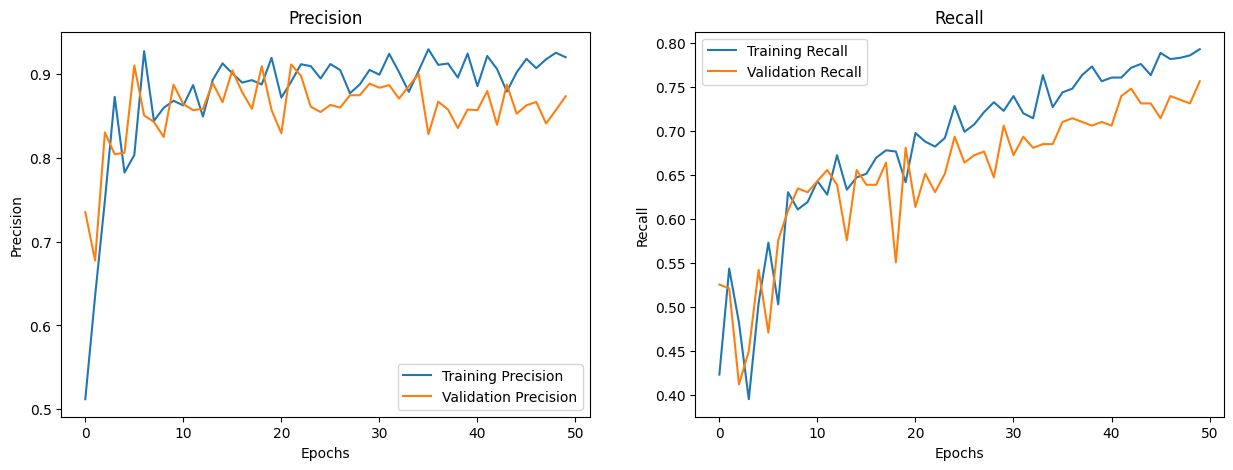

In [86]:
# plots for model 1 + base training set
score = model_base_1.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_1.history['f1_score'], label='Training F1')
plt.plot(history_base_1.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_1.history['loss'], label='Training Loss')
plt.plot(history_base_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_1.history['precision'], label='Training Precision')
plt.plot(history_base_1.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_1.history['recall'], label='Training Recall')
plt.plot(history_base_1.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [87]:
# model 2 + base training set
model_base_2 = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_2 = model_base_2.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - f1_score: 0.0720 - loss: 11.3128 - precision_1: 0.4786 - recall_1: 0.3864 - val_f1_score: 0.1019 - val_loss: 6.2542 - val_precision_1: 0.4874 - val_recall_1: 0.4874
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - f1_score: 0.1285 - loss: 4.2211 - precision_1: 0.5152 - recall_1: 0.4857 - val_f1_score: 0.0986 - val_loss: 2.3132 - val_precision_1: 0.5535 - val_recall_1: 0.3697
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - f1_score: 0.1014 - loss: 1.8003 - precision_1: 0.6403 - recall_1: 0.4271 - val_f1_score: 0.0730 - val_loss: 1.6003 - val_precision_1: 0.8198 - val_recall_1: 0.3824
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - f1_score: 0.0749 - loss: 1.3861 - precision_1: 0.8205 - recall_1: 0.3927 - val_f1_score: 0.0626 - val_loss: 1.4874 - val_precision_1: 0.8734 - val_recall_1: 0.2899
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - f1_score: 0.0671 - loss: 1.3905 - precision_1: 0.8340 - recall_1: 0.3206 - val_f1_s

In [91]:
history_base_2.history.keys()

dict_keys(['f1_score', 'loss', 'precision_1', 'recall_1', 'val_f1_score', 'val_loss', 'val_precision_1', 'val_recall_1'])

F1 Score: 92.40%
Precision: 66.39%
Recall: 18.49%
Loss: 0.5764


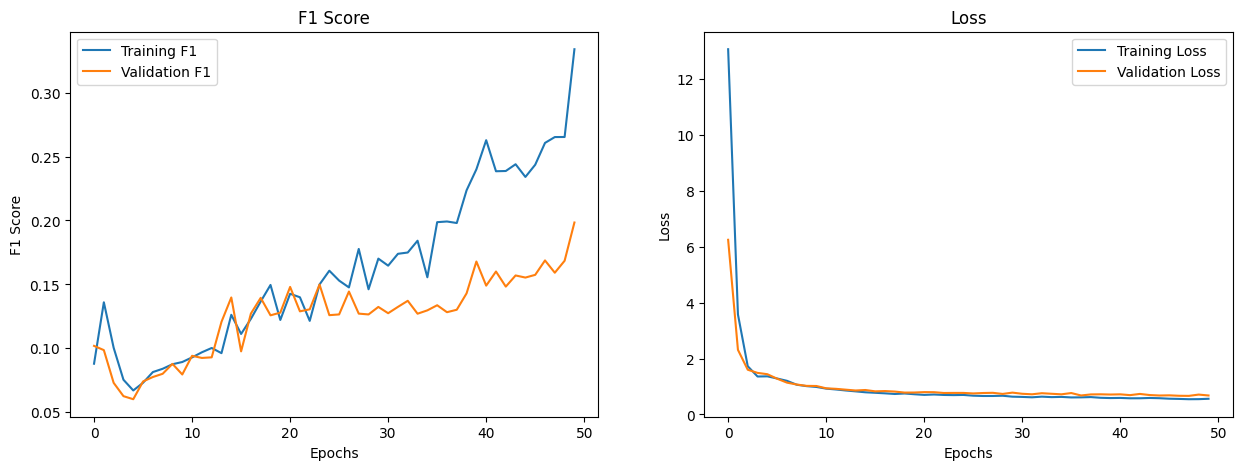

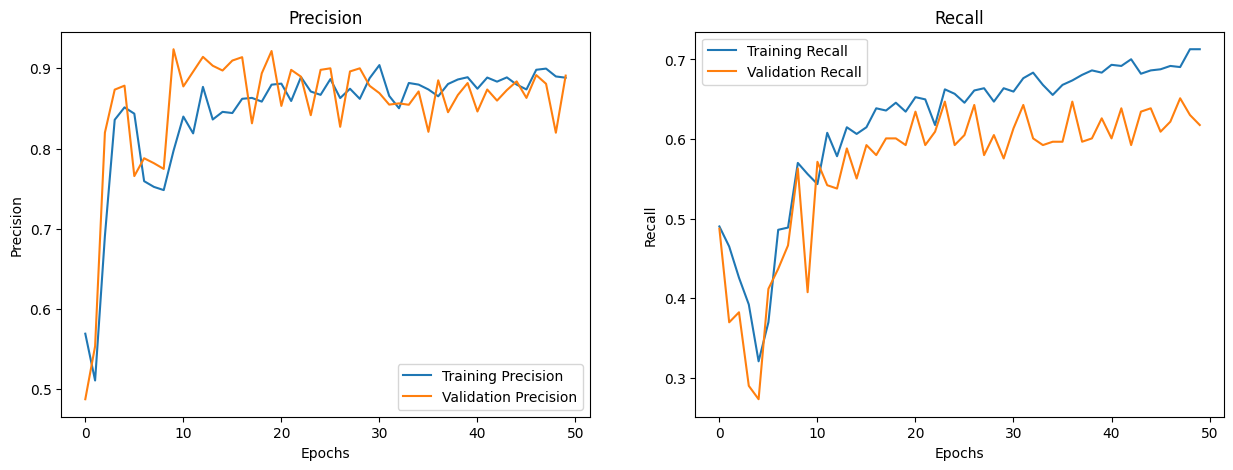

In [92]:
# plots for model 2 + base training set
score = model_base_2.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_2.history['f1_score'], label='Training F1')
plt.plot(history_base_2.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_2.history['loss'], label='Training Loss')
plt.plot(history_base_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_2.history['precision_1'], label='Training Precision')
plt.plot(history_base_2.history['val_precision_1'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_2.history['recall_1'], label='Training Recall')
plt.plot(history_base_2.history['val_recall_1'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [93]:
# model 3 + base training set
model_base_3 = create_cnn_model3(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_3 = model_base_3.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - f1_score: 0.3766 - loss: 10.1770 - precision_2: 0.4481 - recall_2: 0.3604 - val_f1_score: 0.1265 - val_loss: 8.1517 - val_precision_2: 0.1555 - val_recall_2: 0.1555
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - f1_score: 0.3893 - loss: 4.4940 - precision_2: 0.3580 - recall_2: 0.3470 - val_f1_score: 0.5302 - val_loss: 4.2053 - val_precision_2: 0.7425 - val_recall_2: 0.5210
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - f1_score: 0.5217 - loss: 2.4967 - precision_2: 0.7609 - recall_2: 0.5141 - val_f1_score: 0.4562 - val_loss: 1.9832 - val_precision_2: 0.8286 - val_recall_2: 0.3655
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - f1_score: 0.4740 - loss: 1.5140 - precision_2: 0.8766 - recall_2: 0.3836 - val_f1_score: 0.4599 - val_loss: 1.3214 - val_precision_2: 0.8273 - val_recall_2: 0.3824
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - f1_score: 0.5009 - loss: 1.1455 - precision_2: 0.8386 - recall_2: 0.4373 - val_f1_s

In [94]:
history_base_3.history.keys()

dict_keys(['f1_score', 'loss', 'precision_2', 'recall_2', 'val_f1_score', 'val_loss', 'val_precision_2', 'val_recall_2'])

F1 Score: 88.67%
Precision: 75.63%
Recall: 77.48%
Loss: 0.5799


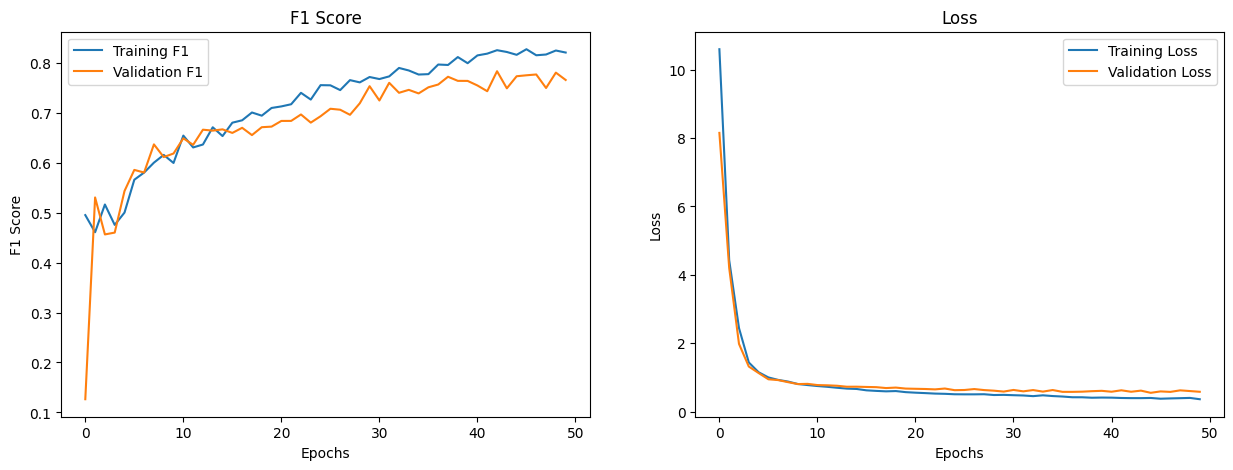

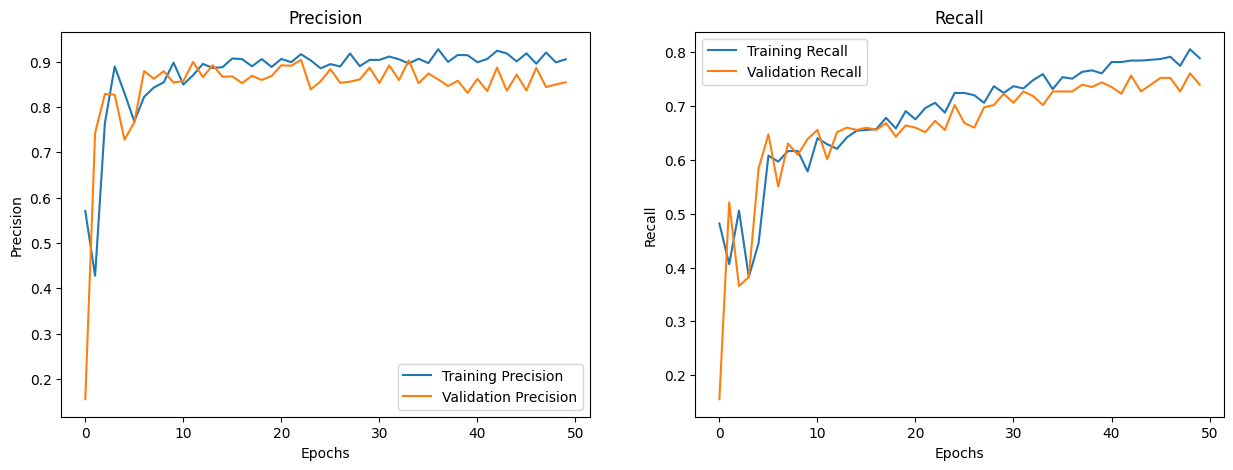

In [95]:
# plots for model 3 + base training set
score = model_base_3.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_3.history['f1_score'], label='Training F1')
plt.plot(history_base_3.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_3.history['loss'], label='Training Loss')
plt.plot(history_base_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_3.history['precision_2'], label='Training Precision')
plt.plot(history_base_3.history['val_precision_2'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_3.history['recall_2'], label='Training Recall')
plt.plot(history_base_3.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

### EXPERIMENT 1: Audio Distortion

In [96]:
# model 1 + augmented training set
model_aug_1 = create_cnn_model1(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_1 = model_aug_1.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - f1_score: 0.0876 - loss: 8.3831 - precision_3: 0.5707 - recall_3: 0.4257 - val_f1_score: 0.0673 - val_loss: 1.3011 - val_precision_3: 0.8941 - val_recall_3: 0.3193
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - f1_score: 0.0787 - loss: 1.1286 - precision_3: 0.8165 - recall_3: 0.4379 - val_f1_score: 0.0915 - val_loss: 0.9655 - val_precision_3: 0.8828 - val_recall_3: 0.5378
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - f1_score: 0.0945 - loss: 0.8867 - precision_3: 0.8629 - recall_3: 0.5514 - val_f1_score: 0.1051 - val_loss: 0.8465 - val_precision_3: 0.8216 - val_recall_3: 0.6387
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - f1_score: 0.1096 - loss: 0.7719 - precision_3: 0.8711 - recall_3: 0.6170 - val_f1_score: 0.1087 - val_loss: 0.7860 - val_precision_3: 0.8342 - val_recall_3: 0.6555
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - f1_score: 0.1266 - loss: 0.7171 - precision_3: 0.8771 - recall_3: 0.6327 -

F1 Score: 83.19%
Precision: 78.99%
Recall: 32.98%
Loss: 0.9936


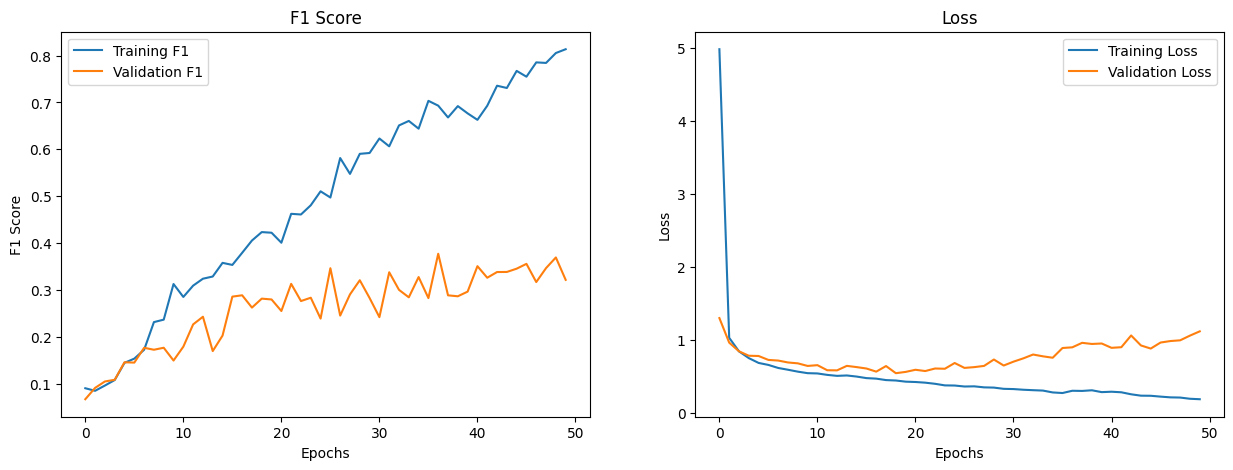

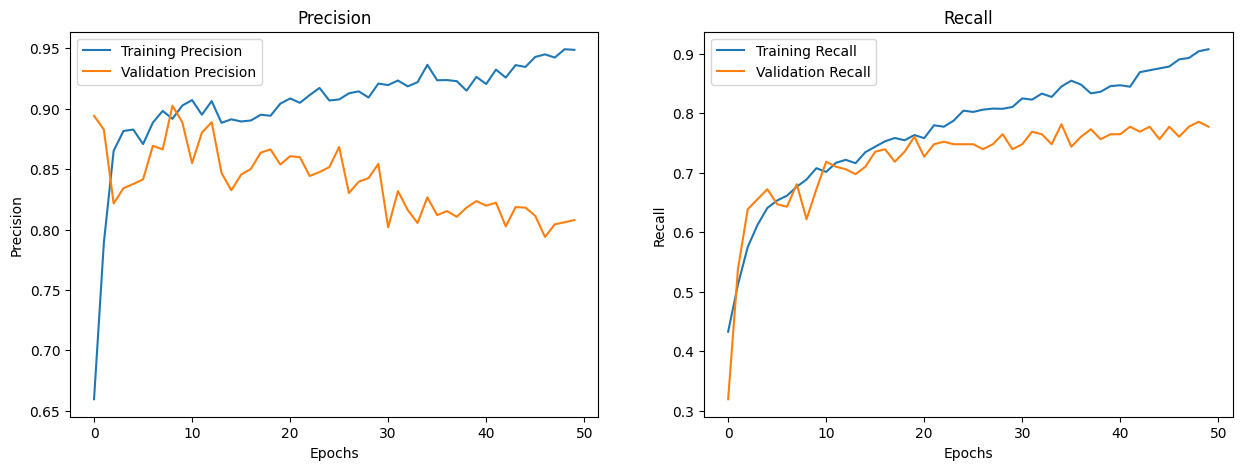

In [99]:
# plots for audio distortion model 1
score = model_aug_1.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_aug_1.history['f1_score'], label='Training F1')
plt.plot(history_aug_1.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_aug_1.history['loss'], label='Training Loss')
plt.plot(history_aug_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_aug_1.history['precision_3'], label='Training Precision')
plt.plot(history_aug_1.history['val_precision_3'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_aug_1.history['recall_3'], label='Training Recall')
plt.plot(history_aug_1.history['val_recall_3'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [100]:
# model 2 + augmented training set
model_aug_2 = create_cnn_model2(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_2 = model_aug_2.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - f1_score: 0.1001 - loss: 7.5076 - precision_4: 0.5506 - recall_4: 0.4354 - val_f1_score: 0.0682 - val_loss: 1.4741 - val_precision_4: 0.8119 - val_recall_4: 0.3445
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - f1_score: 0.0679 - loss: 1.3821 - precision_4: 0.8655 - recall_4: 0.3256 - val_f1_score: 0.0854 - val_loss: 1.1334 - val_precision_4: 0.7486 - val_recall_4: 0.5504
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - f1_score: 0.0856 - loss: 1.0419 - precision_4: 0.7509 - recall_4: 0.5359 - val_f1_score: 0.0894 - val_loss: 0.9847 - val_precision_4: 0.8280 - val_recall_4: 0.5462
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - f1_score: 0.0930 - loss: 0.9122 - precision_4: 0.8289 - recall_4: 0.5836 - val_f1_score: 0.0960 - val_loss: 0.8440 - val_precision_4: 0.8667 - val_recall_4: 0.6008
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - f1_score: 0.1021 - loss: 0.8296 - precision_4: 0.8766 - recall_4: 0.5920 -

F1 Score: 83.49%
Precision: 76.47%
Recall: 25.60%
Loss: 0.7773


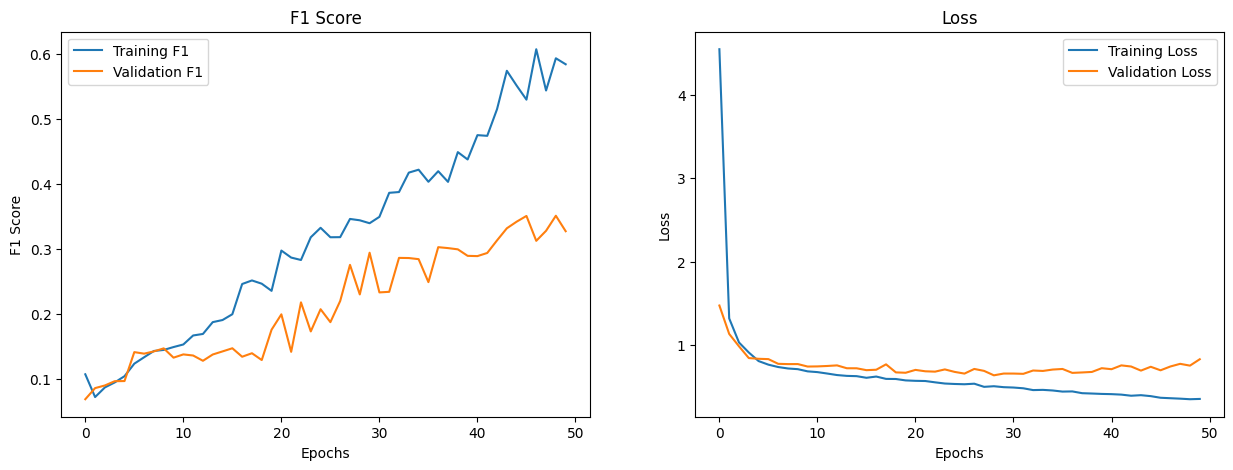

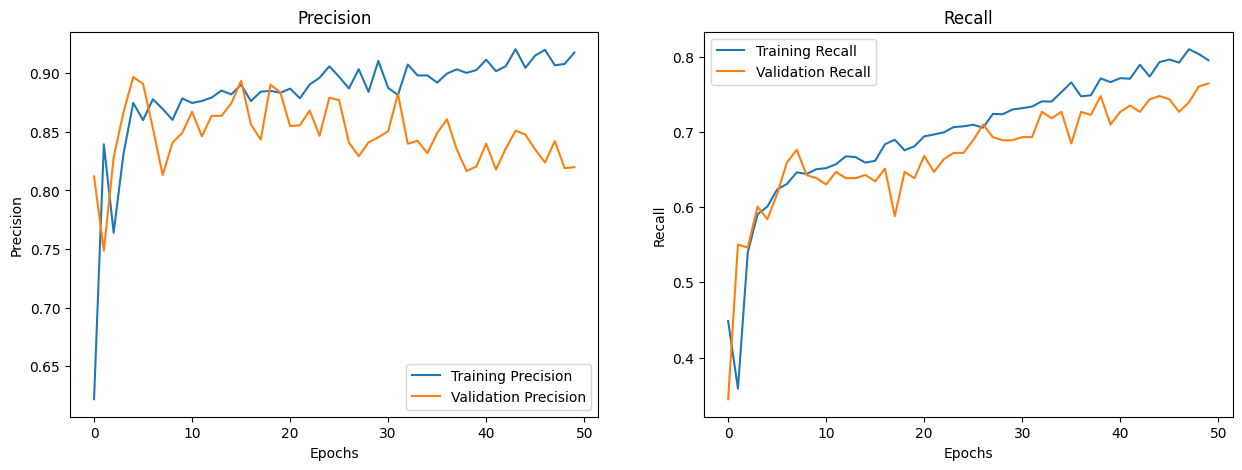

In [102]:
# plots for audio distortion model 2
score = model_aug_2.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_aug_2.history['f1_score'], label='Training F1')
plt.plot(history_aug_2.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_aug_2.history['loss'], label='Training Loss')
plt.plot(history_aug_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_aug_2.history['precision_4'], label='Training Precision')
plt.plot(history_aug_2.history['val_precision_4'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_aug_2.history['recall_4'], label='Training Recall')
plt.plot(history_aug_2.history['val_recall_4'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [103]:
# model 3 + augmented training set
model_aug_3 = create_cnn_model3(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_3 = model_aug_3.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - f1_score: 0.4565 - loss: 7.5363 - precision_5: 0.5391 - recall_5: 0.4299 - val_f1_score: 0.5135 - val_loss: 2.8721 - val_precision_5: 0.7500 - val_recall_5: 0.5042
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - f1_score: 0.4897 - loss: 1.5073 - precision_5: 0.8228 - recall_5: 0.4332 - val_f1_score: 0.5922 - val_loss: 0.9857 - val_precision_5: 0.8054 - val_recall_5: 0.6261
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - f1_score: 0.5885 - loss: 0.8755 - precision_5: 0.8463 - recall_5: 0.5841 - val_f1_score: 0.6273 - val_loss: 0.8244 - val_precision_5: 0.8938 - val_recall_5: 0.6008
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - f1_score: 0.6240 - loss: 0.7829 - precision_5: 0.8654 - recall_5: 0.6114 - val_f1_score: 0.6255 - val_loss: 0.8114 - val_precision_5: 0.8307 - val_recall_5: 0.6597
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - f1_score: 0.6483 - loss: 0.7036 - precision_5: 0.8909 - recall_5: 0.6403 -

In [104]:
history_aug_3.history.keys()

dict_keys(['f1_score', 'loss', 'precision_5', 'recall_5', 'val_f1_score', 'val_loss', 'val_precision_5', 'val_recall_5'])

F1 Score: 82.02%
Precision: 78.57%
Recall: 77.32%
Loss: 0.9887


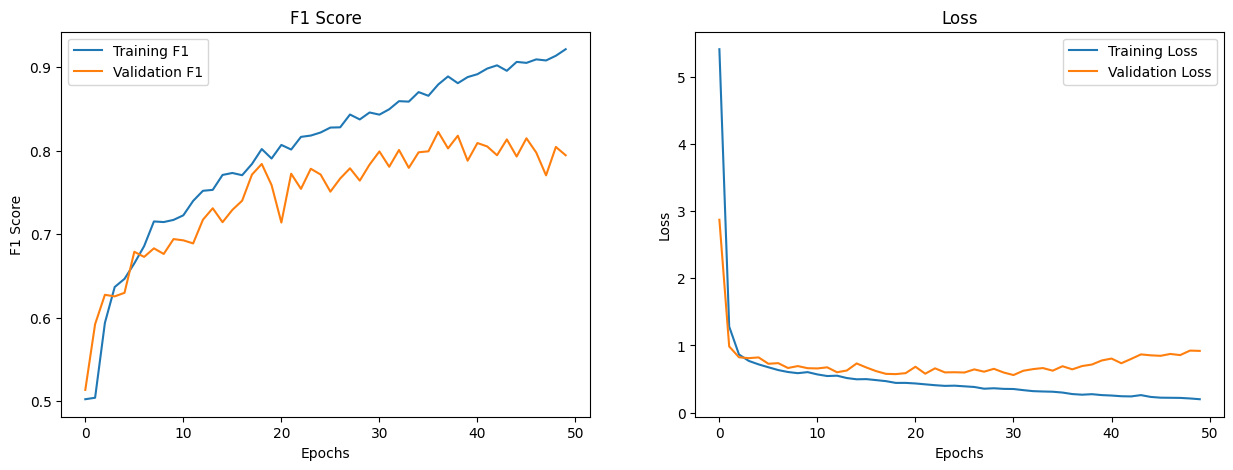

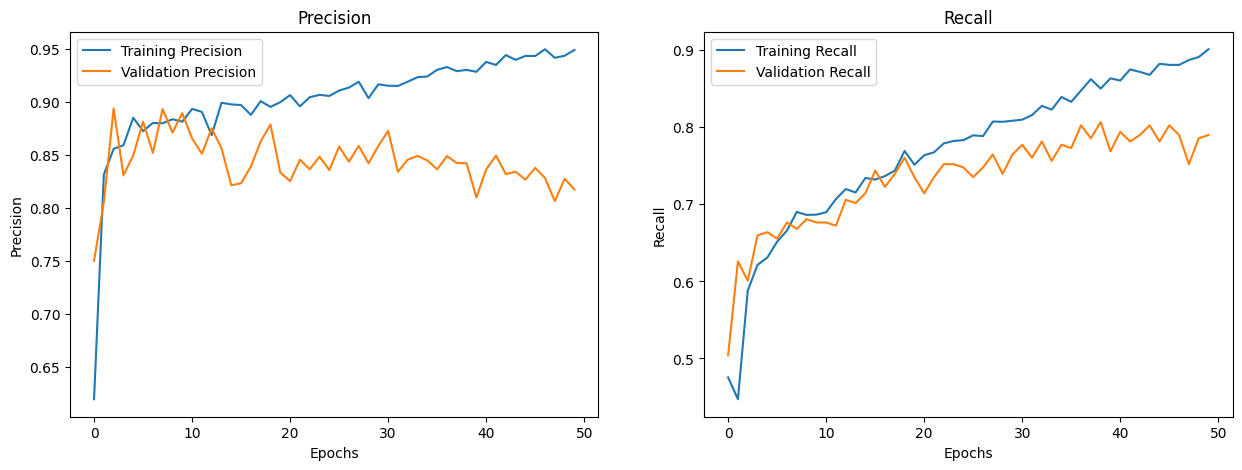

In [105]:
# plots for audio distortion model 3
score = model_aug_3.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_aug_3.history['f1_score'], label='Training F1')
plt.plot(history_aug_3.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_aug_3.history['loss'], label='Training Loss')
plt.plot(history_aug_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_aug_3.history['precision_5'], label='Training Precision')
plt.plot(history_aug_3.history['val_precision_5'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_aug_3.history['recall_5'], label='Training Recall')
plt.plot(history_aug_3.history['val_recall_5'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

### EXPERIMENT 2: Training of specific locations

In [106]:
locations = ['Anterior','Posterior']

results_locations_1 = {}
history_location_1_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_1 = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_1 = model_location_1.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_1_dict[loc] = history_location_1.history

    score = model_location_1.evaluate(location_features_test, y_test, verbose=0)
    results_locations_1[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - f1_score: 0.0807 - loss: 14.7144 - precision_6: 0.4363 - recall_6: 0.3549 - val_f1_score: 0.1004 - val_loss: 6.4418 - val_precision_6: 0.5551 - val_recall_6: 0.5504
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - f1_score: 0.0953 - loss: 4.5204 - precision_6: 0.4861 - recall_6: 0.4487 - val_f1_score: 0.0791 - val_loss: 2.0104 - val_precision_6: 0.7692 - val_recall_6: 0.4622
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - f1_score: 0.0808 - loss: 1.7082 - precision_6: 0.8178 - recall_6: 0.4517 - val_f1_score: 0.0786 - val_loss: 1.6443 - val_precision_6: 0.8125 - val_recall_6: 0.4370
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - f1_score: 0.0854 - loss: 1.4710 - precision_6: 0.8503 - recall_6: 0.4077 - val_f1_score: 0.0981 - val_loss: 1.3935 - val_precision_6: 0.8020 - val_recall_6: 0.3403
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - f1_score: 0.0971 - loss: 1.2383 - precision_6: 0.8815 - recall

F1 Score: 38.02%
Precision: 91.94%
Recall: 77.03%
Loss: 0.3737


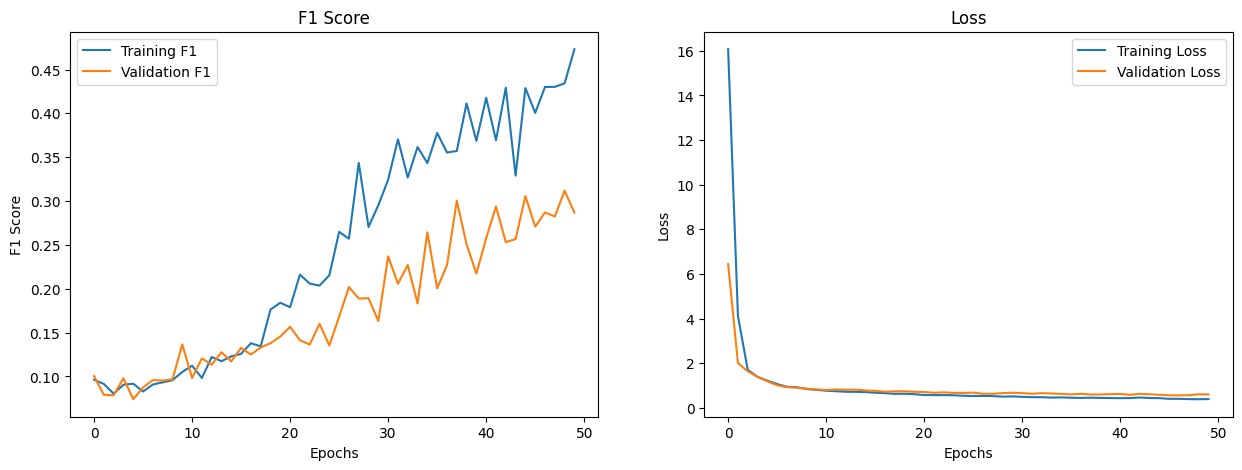

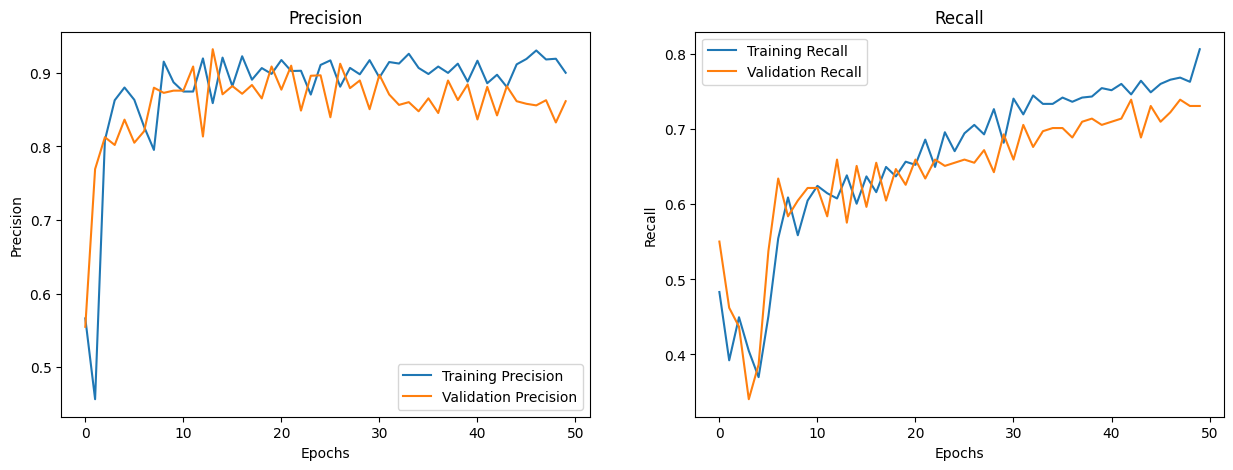

In [128]:
# anterior plots for model 1
print(f"F1 Score: {results_locations_1['Anterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_1['Anterior']['precision']:.2%}")
print(f"Recall: {results_locations_1['Anterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_1['Anterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_1_dict['Anterior']['f1_score'], label='Training F1')
plt.plot(history_location_1_dict['Anterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_1_dict['Anterior']['loss'], label='Training Loss')
plt.plot(history_location_1_dict['Anterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_1_dict['Anterior']['precision_6'], label='Training Precision')
plt.plot(history_location_1_dict['Anterior']['val_precision_6'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_1_dict['Anterior']['recall_6'], label='Training Recall')
plt.plot(history_location_1_dict['Anterior']['val_recall_6'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

F1 Score: 42.44%
Precision: 85.37%
Recall: 69.31%
Loss: 0.6105


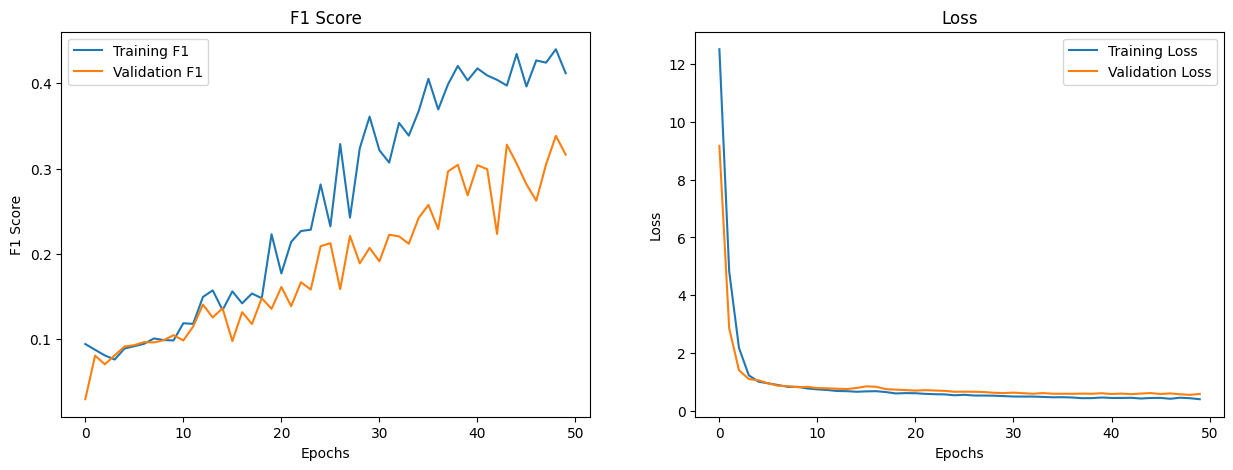

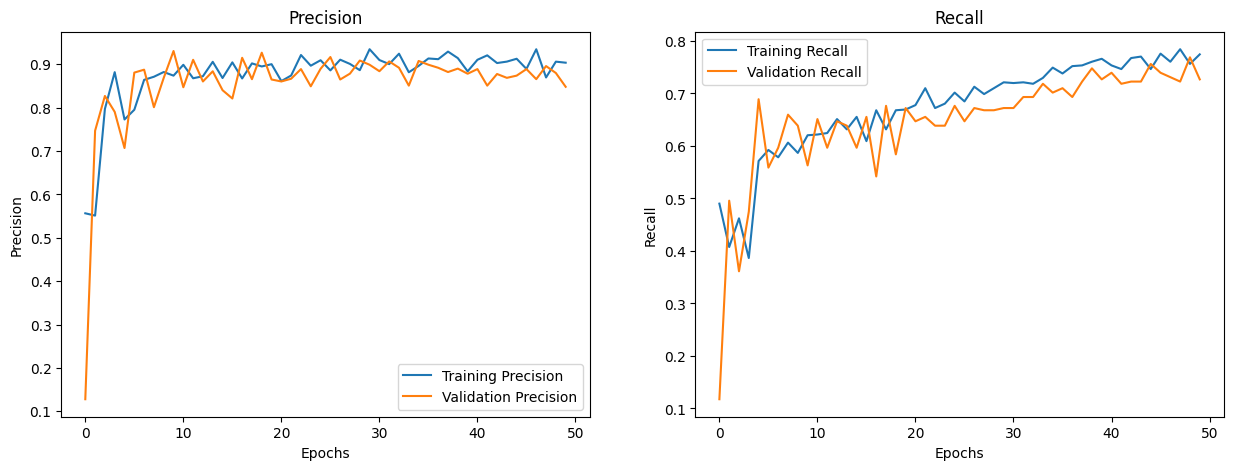

In [131]:
# posterior plots for model 1
print(f"F1 Score: {results_locations_1['Posterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_1['Posterior']['precision']:.2%}")
print(f"Recall: {results_locations_1['Posterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_1['Posterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_1_dict['Posterior']['f1_score'], label='Training F1')
plt.plot(history_location_1_dict['Posterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_1_dict['Posterior']['loss'], label='Training Loss')
plt.plot(history_location_1_dict['Posterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_1_dict['Posterior']['precision_7'], label='Training Precision')
plt.plot(history_location_1_dict['Posterior']['val_precision_7'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_1_dict['Posterior']['recall_7'], label='Training Recall')
plt.plot(history_location_1_dict['Posterior']['val_recall_7'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [133]:
results_locations_2 = {}
history_location_2_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_2 = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_2 = model_location_2.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_2_dict[loc] = history_location_2.history

    score = model_location_2.evaluate(location_features_test, y_test, verbose=0)
    results_locations_2[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - f1_score: 0.0895 - loss: 11.2486 - precision_8: 0.4677 - recall_8: 0.3684 - val_f1_score: 0.1016 - val_loss: 5.1712 - val_precision_8: 0.5474 - val_recall_8: 0.5336
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - f1_score: 0.1114 - loss: 3.6716 - precision_8: 0.4959 - recall_8: 0.4509 - val_f1_score: 0.0786 - val_loss: 2.2340 - val_precision_8: 0.7676 - val_recall_8: 0.4580
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - f1_score: 0.0851 - loss: 1.7757 - precision_8: 0.7714 - recall_8: 0.4673 - val_f1_score: 0.0796 - val_loss: 2.0708 - val_precision_8: 0.7419 - val_recall_8: 0.4832
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - f1_score: 0.0833 - loss: 1.6814 - precision_8: 0.7713 - recall_8: 0.4928 - val_f1_score: 0.0733 - val_loss: 1.5283 - val_precision_8: 0.7680 - val_recall_8: 0.4034
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - f1_score: 0.0780 - loss: 1.4049 - precision_8: 0.8077 - recall

F1 Score: 24.07%
Precision: 92.98%
Recall: 71.62%
Loss: 0.5206


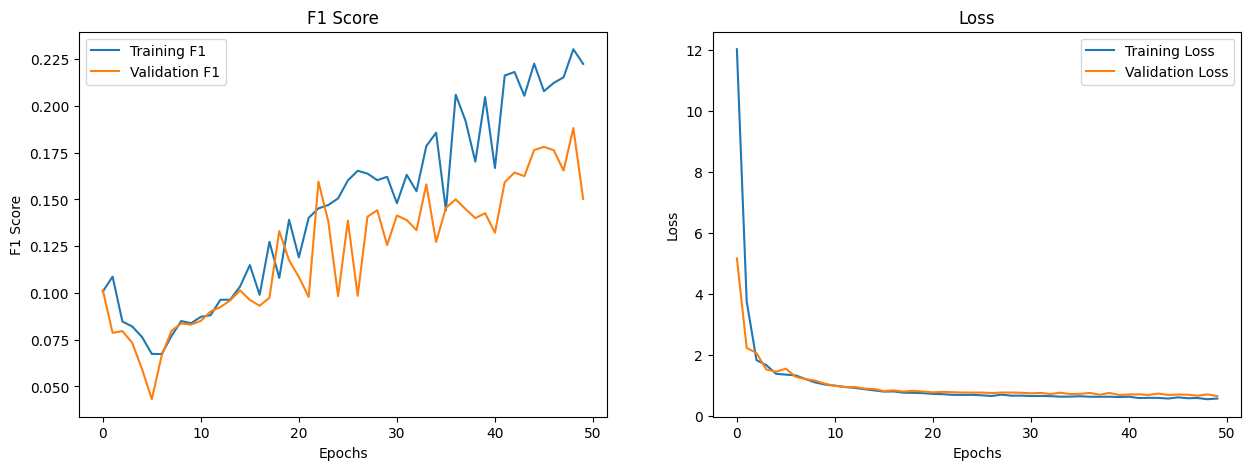

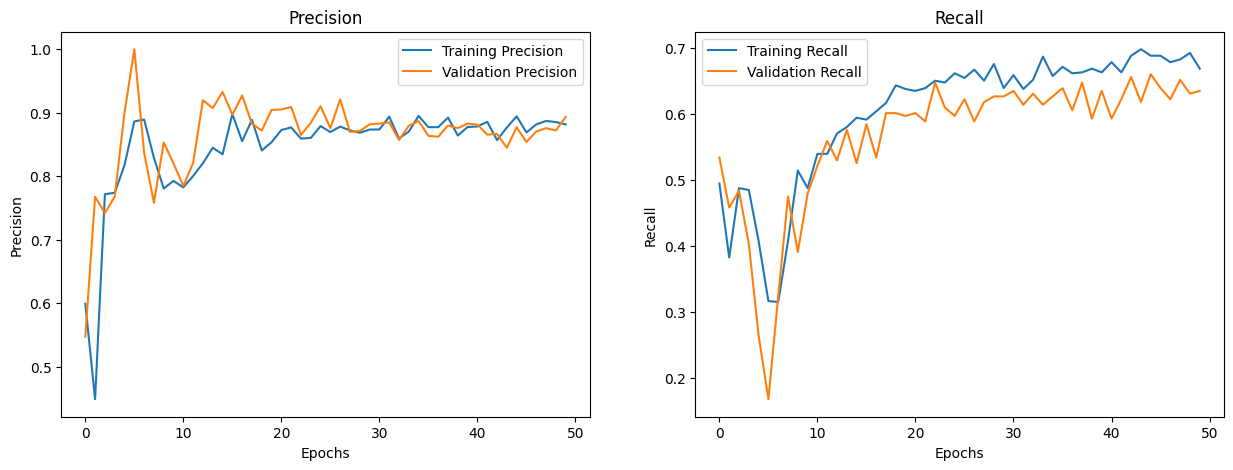

In [134]:
# anterior plots for model 2
print(f"F1 Score: {results_locations_2['Anterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_2['Anterior']['precision']:.2%}")
print(f"Recall: {results_locations_2['Anterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_2['Anterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_2_dict['Anterior']['f1_score'], label='Training F1')
plt.plot(history_location_2_dict['Anterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_2_dict['Anterior']['loss'], label='Training Loss')
plt.plot(history_location_2_dict['Anterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_2_dict['Anterior']['precision_8'], label='Training Precision')
plt.plot(history_location_2_dict['Anterior']['val_precision_8'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_2_dict['Anterior']['recall_8'], label='Training Recall')
plt.plot(history_location_2_dict['Anterior']['val_recall_8'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

F1 Score: 34.91%
Precision: 93.75%
Recall: 59.41%
Loss: 0.6528


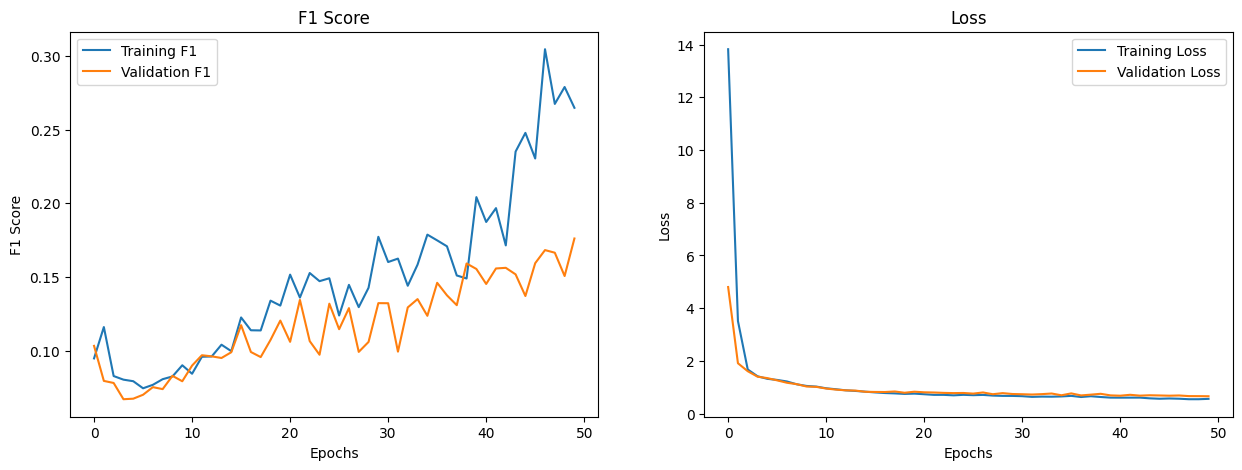

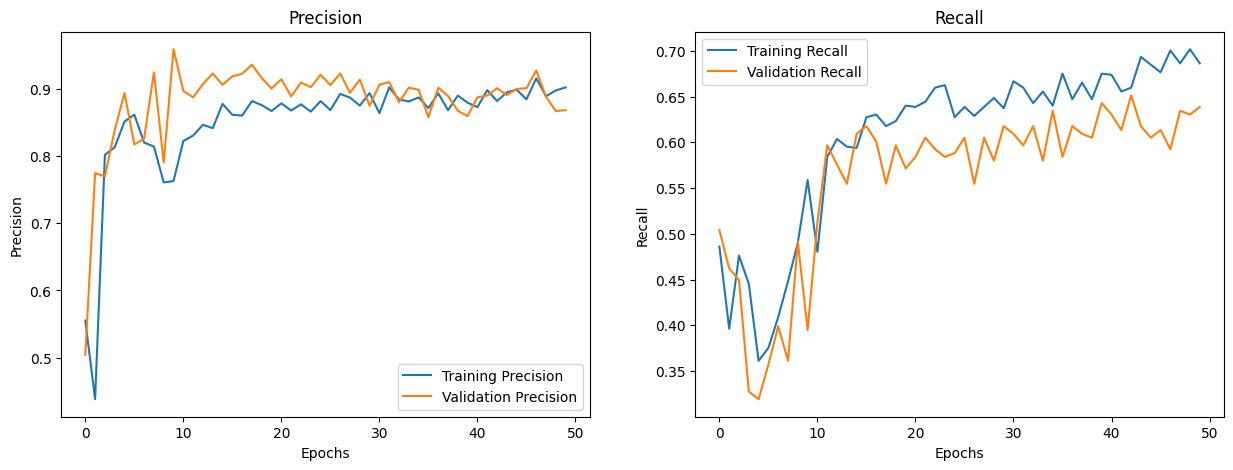

In [135]:
# posterior plots for model 2
print(f"F1 Score: {results_locations_2['Posterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_2['Posterior']['precision']:.2%}")
print(f"Recall: {results_locations_2['Posterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_2['Posterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_2_dict['Posterior']['f1_score'], label='Training F1')
plt.plot(history_location_2_dict['Posterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_2_dict['Posterior']['loss'], label='Training Loss')
plt.plot(history_location_2_dict['Posterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_2_dict['Posterior']['precision_9'], label='Training Precision')
plt.plot(history_location_2_dict['Posterior']['val_precision_9'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_2_dict['Posterior']['recall_9'], label='Training Recall')
plt.plot(history_location_2_dict['Posterior']['val_recall_9'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [137]:
results_locations_3 = {}
history_location_3_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_3 = create_cnn_model3(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_3= model_location_3.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_3_dict[loc] = history_location_3.history

    score = model_location_3.evaluate(location_features_test, y_test, verbose=0)
    results_locations_3[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - f1_score: 0.3788 - loss: 10.1956 - precision_10: 0.4897 - recall_10: 0.3675 - val_f1_score: 0.5300 - val_loss: 5.9863 - val_precision_10: 0.5401 - val_recall_10: 0.5378
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - f1_score: 0.4913 - loss: 3.8426 - precision_10: 0.5146 - recall_10: 0.4568 - val_f1_score: 0.4856 - val_loss: 1.6236 - val_precision_10: 0.8031 - val_recall_10: 0.4286
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - f1_score: 0.5106 - loss: 1.3375 - precision_10: 0.8656 - recall_10: 0.4224 - val_f1_score: 0.4616 - val_loss: 1.3450 - val_precision_10: 0.8349 - val_recall_10: 0.3824
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - f1_score: 0.4903 - loss: 1.2466 - precision_10: 0.8302 - recall_10: 0.4291 - val_f1_score: 0.4975 - val_loss: 1.1047 - val_precision_10: 0.7985 - val_recall_10: 0.4496
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - f1_score: 0.5117 - loss: 1.0338 - precision_10

F1 Score: 84.19%
Precision: 90.77%
Recall: 79.73%
Loss: 0.3188


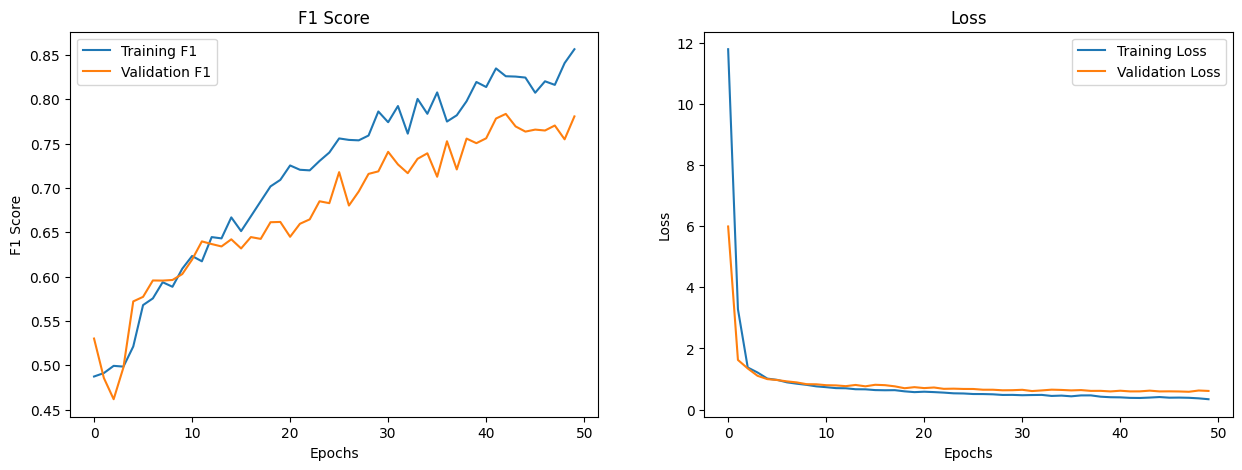

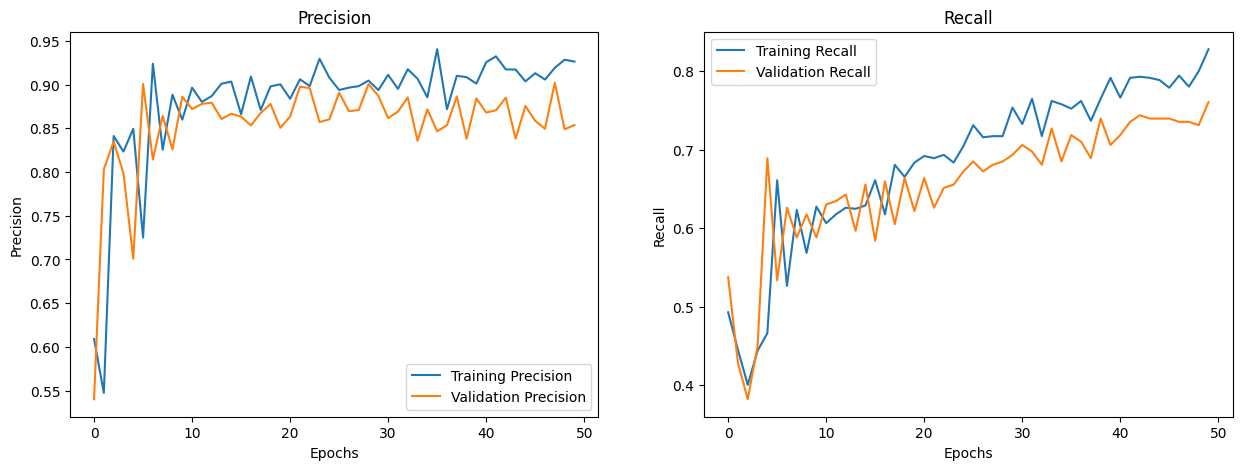

In [138]:
# anterior plots for model 3
print(f"F1 Score: {results_locations_3['Anterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_3['Anterior']['precision']:.2%}")
print(f"Recall: {results_locations_3['Anterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_3['Anterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_3_dict['Anterior']['f1_score'], label='Training F1')
plt.plot(history_location_3_dict['Anterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_3_dict['Anterior']['loss'], label='Training Loss')
plt.plot(history_location_3_dict['Anterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_3_dict['Anterior']['precision_10'], label='Training Precision')
plt.plot(history_location_3_dict['Anterior']['val_precision_10'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_3_dict['Anterior']['recall_10'], label='Training Recall')
plt.plot(history_location_3_dict['Anterior']['val_recall_10'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

F1 Score: 74.19%
Precision: 89.74%
Recall: 69.31%
Loss: 0.5158


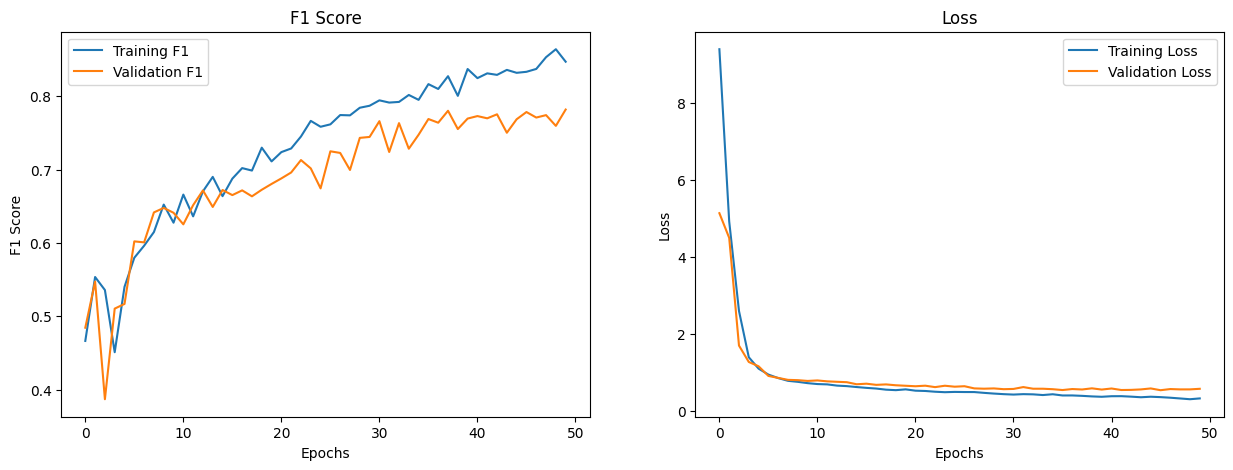

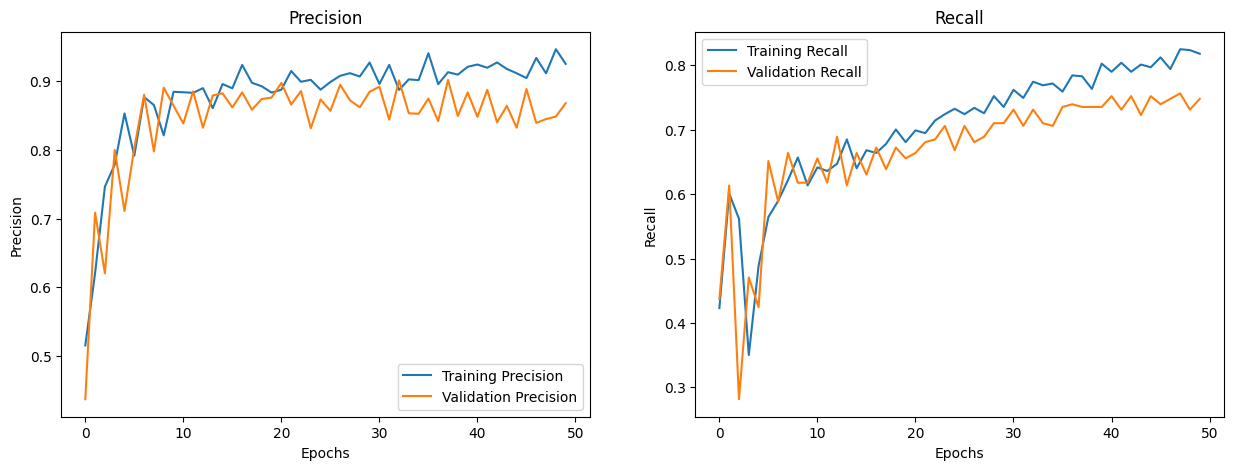

In [139]:
# posterior plots for model 3
print(f"F1 Score: {results_locations_3['Posterior']['f1_score']:.2%}")
print(f"Precision: {results_locations_3['Posterior']['precision']:.2%}")
print(f"Recall: {results_locations_3['Posterior']['recall']:.2%}")
print("Loss: {:.4f}".format(results_locations_3['Posterior']['loss']))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_location_3_dict['Posterior']['f1_score'], label='Training F1')
plt.plot(history_location_3_dict['Posterior']['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_location_3_dict['Posterior']['loss'], label='Training Loss')
plt.plot(history_location_3_dict['Posterior']['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_location_3_dict['Posterior']['precision_11'], label='Training Precision')
plt.plot(history_location_3_dict['Posterior']['val_precision_11'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_location_3_dict['Posterior']['recall_11'], label='Training Recall')
plt.plot(history_location_3_dict['Posterior']['val_recall_11'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

# Appendix

1. We based our intial architecture for our CNN and CNN plots (like loss) off of this code: https://www.kaggle.com/code/markdenton/cnn-disease-classification-linked-features-95


2. Used ChatGPT free version to help format the input array for our CNN models:
    `padded = padded[..., np.newaxis]`